# Solving QUBO/Ising Problems via Unit-Disk Graphs on Neutral Atom Quantum Computers

## 1. Introduction

### 1.1. The QUBO/Ising Problem

Combinatorial optimization problems are ubiquitous in fields ranging from logistics and finance to drug discovery and materials science. Many of these problems can be formulated as finding the ground state of an Ising model or, equivalently, minimizing a Quadratic Unconstrained Binary Optimization (QUBO) objective function.

The **Ising model**, originating from statistical mechanics, describes interacting spins on a lattice. Its energy (Hamiltonian) is given by:

$$ E_{Ising}(z) = -\sum_{i<j} J_{ij} z_i z_j - \sum_i h_i z_i $$

where $z_i \in \{-1, +1\}$ are spin variables, $J_{ij}$ represents the coupling strength between spins $i$ and $j$, and $h_i$ is an external magnetic field acting on spin $i$.

The **QUBO** problem seeks to minimize a quadratic polynomial of binary variables $x_i \in \{0, 1\}$:

$$ E_{QUBO}(x) = \sum_{i \le j} Q_{ij} x_i x_j $$

These two formulations are equivalent through the transformation $x_i = (1 - z_i) / 2$. Finding the configuration $(z_i)$ or $(x_i)$ that minimizes the respective energy function is often computationally hard (NP-hard in general), motivating the search for efficient solution methods, including quantum algorithms.

### 1.2. Neutral Atom Quantum Computers

Neutral atom arrays have emerged as a highly promising platform for quantum computation and simulation. In these systems, individual neutral atoms are trapped using optical tweezers, allowing for precise arrangement in 1D, 2D, or even 3D geometries. Quantum information is typically encoded in two electronic states of each atom: a ground state $|g\rangle$ and a highly excited Rydberg state $|r\rangle$. Lasers are used to drive transitions between these states ($\Omega$) and control their energy difference (detuning $\delta$).

A key feature is the strong, long-range interaction between atoms in the Rydberg state ($|r\rangle$). This interaction falls off rapidly with distance $R$ (typically as $C_6/R^6$).

### 1.3. The Blockade Mechanism

The strong Rydberg interaction leads to the **Rydberg blockade** effect: if one atom is excited to $|r\rangle$, the energy levels of nearby atoms are shifted significantly, preventing them from being resonantly excited to $|r\rangle$ by the same laser field. This blockade occurs within a characteristic radius $R_b$.

Effectively, this means that only atoms separated by a distance greater than $R_b$ can be simultaneously excited to the Rydberg state. This naturally implements the constraint of an **Independent Set** on a graph where atoms are vertices and edges connect atoms closer than $R_b$. Such a graph, where connectivity is determined solely by distance, is known as a **Unit-Disk Graph (UDG)**.

However, many QUBO/Ising problems derived from real-world applications feature complex, arbitrary connectivity patterns ($J_{ij}$ can be non-zero for distant pairs $i, j$). This presents a challenge: how can we solve problems with arbitrary connectivity on hardware whose native interactions are geometrically constrained (UDG-like)?

### 1.4. Unit-Disk Mapping (UDM): Bridging the Gap

**Unit-Disk Mapping (UDM)** is a technique designed to address this connectivity mismatch. It provides a systematic way to embed or encode an optimization problem with arbitrary connectivity (like a general QUBO/Ising model) into a new problem defined on a Unit-Disk Graph, such that the solution to the UDG problem corresponds directly to the solution of the original problem. The goal is to construct a UDG whose ground state encodes the ground state of the original Ising Hamiltonian, making it solvable on neutral atom hardware.

### 1.5. UDM via Maximum Weight Independent Set (MWIS)

The specific UDM approach we explore here, detailed in [Nguyen et al., PRX Quantum 4, 010316 (2023)](https://doi.org/10.1103/PRXQuantum.4.010316), transforms the QUBO/Ising problem into an instance of the **Maximum Weight Independent Set (MWIS)** problem on a specially constructed UDG.

The MWIS problem on a graph $G=(V, E)$ with node weights $w_i$ asks for a subset of vertices $S \subseteq V$ such that no two vertices in $S$ are connected by an edge (it's an independent set), and the sum of weights of vertices in $S$ ($\sum_{i \in S} w_i$) is maximized.

The UDM construction involves:
1.  Representing each original variable $z_i$ using a chain of connected nodes (a "copy gadget") within the UDG.
2.  Using specialized "crossing gadgets" to allow these variable lines to cross without interacting, enabling arbitrary arrangements.
3.  Modifying crossing gadgets ("crossing-with-edge" or weighted crossing gadgets) at points corresponding to non-zero $J_{ij}$ or $h_i$ terms in the original problem. These modifications adjust local node weights within the UDG.
4.  Carefully choosing the weights such that the MWIS of the final UDG corresponds to the ground state configuration of the original QUBO/Ising problem. The independent set constraint enforced by the Rydberg blockade naturally prevents conflicting assignments within the gadgets.


A pictorial description of the graph construction is shown in Fig. 7 of the original paper:

![alt text](https://journals.aps.org/prxquantum/article/10.1103/PRXQuantum.4.010316/figures/7/large)

This mapping allows us to leverage the native UDG constraints of neutral atom hardware to solve arbitrarily connected problems. The following sections detail how to perform this mapping using the `qamomile` library and simulate the solution using quantum simulators like [`bloqade-analog`](https://github.com/QuEraComputing/bloqade-analog) and [`pulser`](https://pulser.readthedocs.io/en/stable/).

In [ ]:
# Install dependencies
# This notebook requires the following packages:
# - bloqade-analog
# - pulser
!pip install bloqade-analog pulser

In [ ]:
# Install Qamomile (The forked version)
# !git clone https://github.com/nez0b/Qamomile
# !pip install -e .

## 2. Unit-Disk Mapping with `qamomile`

### 2.1. Overview

The [`qamomile`](https://github.com/Jij-Inc/Qamomile) library provides tools to facilitate the Unit-Disk Mapping process. Specifically, the `qamomile.core` and `qamomile.udm` modules contain classes and functions to represent Ising models, perform the mapping to a Unit-Disk Graph, and solve the resulting MWIS problem.

### 2.2. Representing the Problem: `IsingModel` Class

First, we define the QUBO or Ising problem using the `IsingModel` class from `qamomile.core.ising_qubo`. This class stores the quadratic couplings ($J_{ij}$), linear biases ($h_i$), and any constant offset.

In [ ]:
from qamomile.core.ising_qubo import IsingModel

# Define quadratic couplings (J_ij)
quad = {
    (0, 1): 1.0,   # Example: Coupling between spins 0 and 1
    (0, 2): -0.5,  # Example: Coupling between spins 0 and 2
    (1, 2): 0.8
}

# Define linear biases (h_i)
linear = {
    0: 0.1,   # Example: Bias on spin 0
    1: -0.2,
    2: 0.3
}

# Create the Ising model instance
ising_model = IsingModel(quad=quad, linear=linear, constant=0.0)

print(f"Created Ising model with {ising_model.num_bits()} spins.")

Created Ising model with 3 spins.


As discussed in the UDM paper (Appendix B), proper normalization of the coupling and bias strengths is crucial to ensure the MWIS solution of the mapped graph correctly corresponds to the ground state of the original problem. `IsingModel` provides normalization methods. We typically use `normalize_by_abs_max` before mapping:

In [ ]:
# Create a copy to avoid modifying the original
import copy
normalized_ising_model = copy.deepcopy(ising_model)
normalized_ising_model.normalize_by_abs_max()
print("Normalized model coefficients (example):")
print(" Linear:", normalized_ising_model.linear)
print(" Quad:", normalized_ising_model.quad)

Normalized model coefficients (example):
 Linear: {0: 0.1, 1: -0.2, 2: 0.3}
 Quad: {(0, 1): 1.0, (0, 2): -0.5, (1, 2): 0.8}


This scales all $J_{ij}$ and $h_i$ such that the largest absolute value becomes 1.

### 2.3. Performing the Mapping: `UnitDiskGraph` Class

The `UnitDiskGraph` class (also in `qamomile.core.ising_qubo`) handles the conversion from an `IsingModel` to the UDG representation.

In [ ]:
from qamomile.udm import Ising_UnitDiskGraph

# Convert the (normalized) Ising model to a Unit Disk Graph
# This happens automatically when the UnitDiskGraph object is created
udg = Ising_UnitDiskGraph(ising_model)

# Alternatively, use the convenience method from IsingModel
# udg = ising_model.to_unit_disk_graph(normalize=True) # Normalizes internally

print(f"Converted to Unit Disk Graph:")
print(f"- {len(udg.nodes)} nodes in the grid graph")
print(f"- {len(udg.pins)} pins (nodes corresponding to original variables)")

Overwriting delta from 2.7 to 1.5
Converted to Unit Disk Graph:
- 26 nodes in the grid graph
- 3 pins (nodes corresponding to original variables)


Behind the scenes, creating the `UnitDiskGraph` object triggers the `_create_mapping` method, which performs the core UDM steps:
1.  **Converts** the `quad` and `linear` dictionaries into a symmetric coupling matrix `J` and a bias vector `h`.
2.  **Calculates** a scaling parameter `delta`. This parameter sets the base energy scale for the gadgets in the UDG. It's chosen based on the maximum absolute values in `J` and `h` (e.g., `delta = 1.5 * max(max(abs(J)), max(abs(h)))`) to satisfy the normalization constraints discussed in the UDM paper, ensuring defects are energetically penalized.
3.  **Calls** the function `qamomile.udm.map_qubo(J, h, delta)` (from `dragondrop.py`). This function implements the main mapping algorithm:
    *   It constructs the "crossing lattice" structure.
    *   It places appropriate gadgets (copy gadgets along lines, crossing/QUBO gadgets at intersections) onto a grid.
    *   It assigns weights to the nodes within these gadgets. Crucially, the weights in the core of the QUBO crossing gadgets are set based on the corresponding $J_{ij}$ value and `delta` (e.g., $4\delta \pm J_{ij}$), encoding the quadratic interaction.
    *   It adjusts the weights of the "pin" nodes (boundary nodes of the copy lines) based on the bias vector `h` and `delta` (e.g., $\delta \pm h_i$), encoding the linear terms.
4.  **Stores** the result, including the list of nodes (`udg.nodes`, each with a location `node.loc` and `node.weight`) and the indices of the pin nodes (`udg.pins`), which represent the original variables.

The output is a representation of the original Ising problem as a weighted graph embedded in 2D space, satisfying the unit-disk property.

### 2.4. Visualizing the UDG

We can visualize the resulting UDG structure using `networkx` and `matplotlib`. The `UnitDiskGraph` object provides access to the underlying graph structure.

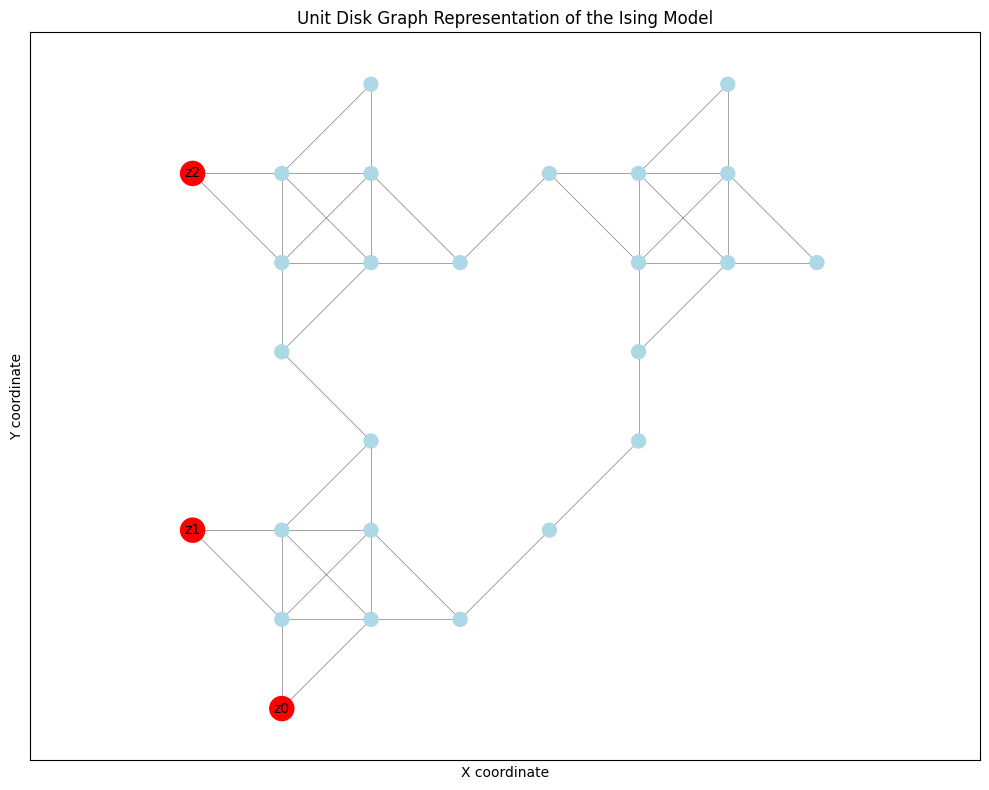

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import os # For creating directory

# Ensure 'img' directory exists
os.makedirs("img", exist_ok=True)

# Get the NetworkX graph representation from the UDG object
# This graph has nodes with 'pos' and 'weight' attributes
G_vis = udg.networkx_graph

# Get positions and pin indices
pos = nx.get_node_attributes(G_vis, 'pos')
pins = udg.pins

# Draw the graph
plt.figure(figsize=(10, 8))

# Highlight pins (original variables)
node_colors = ['red' if i in pins else 'lightblue' for i in G_vis.nodes()]
node_sizes = [300 if i in pins else 100 for i in G_vis.nodes()]

nx.draw_networkx_nodes(G_vis, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G_vis, pos, width=0.5, alpha=0.5)

# Label the pins with their original variable index
pin_labels = {pin: f"z{i}" for i, pin in enumerate(pins)} # Use z_i for Ising spins
nx.draw_networkx_labels(G_vis, pos, labels=pin_labels, font_size=10)

plt.title("Unit Disk Graph Representation of the Ising Model")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.axis('equal') # Ensure aspect ratio is maintained
plt.tight_layout()
#plt.savefig("img/unit_disk_graph_vis.png")
#plt.close() # Close the plot to free memory
plt.show()

#print("Saved UDG visualization to img/unit_disk_graph_vis.png")

This visualization helps understand how the abstract Ising problem is physically laid out using the UDM gadgets.

### 2.5. Solving Classically: MWIS via MILP

The UDM transforms the Ising problem into finding the Maximum Weight Independent Set (MWIS) on the generated `UnitDiskGraph`. We can solve this classically using standard optimization techniques, specifically Mixed-Integer Linear Programming (MILP).

The `udg.solve()` method provides a convenient way to do this:

In [ ]:
# Solve the MWIS problem on the UDG using the default MILP solver
# The result is automatically mapped back to the original Ising variables
solution_result = udg.solve() # False for {-1, +1} Ising spins

print("\nClassical Solution via MWIS-MILP:")
print(f"- Solution method: {solution_result['solution_method']}") # Should be 'mwis'
print(f"- Original spin configuration (z_i): {solution_result['original_config']}")
print(f"- Calculated energy: {solution_result['energy']:.4f}")

# For small problems, we can compare with brute force (done internally by solve if possible)
if 'brute_force_result' in solution_result:
    bf_energy = solution_result['brute_force_result']['min_energy']
    bf_config = solution_result['brute_force_result']['best_config']
    print(f"- Brute force energy: {bf_energy:.4f}")
    print(f"- Brute force config: {bf_config}")
    if abs(solution_result['energy'] - bf_energy) < 1e-6:
        print("  (MWIS solution matches brute force)")
    else:
        print("  (MWIS solution differs from brute force - check normalization/mapping)")

# We can also access the raw MWIS solution vector if needed
# solution_vector_mwis = solution_result['solution_vector'] # Binary vector for UDG nodes
# selected_udg_nodes = solution_result['selected_nodes'] # Indices of UDG nodes in MWIS
# mwis_total_weight = solution_result['mwis_weight'] # Sum of weights of selected UDG nodes


Classical Solution via MWIS-MILP:
- Solution method: mwis
- Original spin configuration (z_i): [-1.0, 1.0, -1.0]
- Calculated energy: -5.2000
- Brute force energy: -5.2000
- Brute force config: [-1, 1, -1]
  (MWIS solution matches brute force)


The `udg.solve()` method calls `qamomile.udm.solve_qubo`, which, for the MWIS approach, performs these steps:
1.  Generates the `networkx` graph representation of the UDG (`qubo_result_to_networkx`).
2.  Calls `qamomile.udm.solve_mwis_scipy(G)` to solve the MWIS problem using MILP.
3.  Uses `qamomile.udm.map_config_back` to translate the MWIS solution back to the original Ising spin configuration.

**Explanation of the MILP Formulation for MWIS:**

The `solve_mwis_scipy(G)` function formulates the MWIS problem as follows:

*   **Variables:** For each node $i$ in the Unit-Disk Graph $G=(V, E)$, we define a binary variable $x_i \in \{0, 1\}$. $x_i = 1$ signifies that node $i$ is included in the independent set, and $x_i = 0$ signifies it is not.
*   **Objective Function:** We want to maximize the sum of weights of the selected nodes. Let $w_i$ be the weight of node $i$ (obtained from `G.nodes[i]['weight']`). The objective is:
    $$ \text{Maximize} \sum_{i \in V} w_i x_i $$
    Since `scipy.optimize.milp` performs minimization, the objective coefficients `c` are set to the *negative* weights: $c_i = -w_i$. The solver minimizes $\sum_i c_i x_i = -\sum_i w_i x_i$, which is equivalent to maximizing the original sum.
*   **Constraints:** The core requirement of an independent set is that no two connected nodes can be selected simultaneously. For every edge $(u, v) \in E$ in the UDG, we must enforce the constraint:
$$ x_u + x_v \leq 1 $$

    This ensures that if $x_u=1$, then $x_v$ must be 0, and vice-versa. It also allows both to be 0. These constraints are formulated as `LinearConstraint(A_ub, -np.inf, b_ub)` where `A_ub` is a matrix where each row corresponds to an edge $(u,v)$ and has 1s in the columns for $u$ and $v$, and `b_ub` is a vector of 1s.
*   **Bounds and Integrality:** Each variable $x_i$ must be between 0 and 1 (`Bounds([0]*n, [1]*n)`), and crucially, they must be integers (`integrality=np.ones(n, dtype=bool)`). Combined with the bounds, this forces $x_i$ to be binary.

The `scipy.optimize.milp` function takes these components (`c`, `constraints`, `bounds`, `integrality`) and uses algorithms like branch-and-cut to find the optimal binary vector `res.x` that satisfies the constraints and minimizes the objective function. The indices $i$ where `res.x[i]` is close to 1 form the MWIS.

### 2.6. Mapping the Solution Back

The binary solution vector `solution_vector` obtained from `solve_mwis_scipy` indicates which nodes *in the UDG* are part of the MWIS. The function `map_config_back(qubo_result, solution_vector, binary=False)` translates this back to the original problem variables (Ising spins $z_i \in \{-1, +1\}$). It does this by looking at the state of the specific "pin" nodes in the UDG solution vector, which correspond to the original variables. The exact mapping depends on the gadget construction (e.g., whether pin node selected corresponds to $z_i=+1$ or $z_i=-1$).

### 2.7. Complete Code Example (Mapping & Classical Solve)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
import copy

from qamomile.core.ising_qubo import IsingModel
from qamomile.udm import Ising_UnitDiskGraph

# --- 1. Define Ising Problem ---
quad = {(0, 1): 1.0, (0, 2): -0.5, (1, 2): 0.8}
linear = {0: 0.1, 1: -0.2, 2: 0.3}
ising_model = IsingModel(quad=quad, linear=linear, constant=0.0)
print("Original Ising Model:")
print(f" H = {ising_model.quad} Z_i Z_j + {ising_model.linear} Z_i + {ising_model.constant}")

# --- 2. Map to UDG (with normalization) ---
udg = Ising_UnitDiskGraph(ising_model)
print(f"\nCreated UDG with {len(udg.nodes)} nodes and {len(udg.pins)} pins.")

# --- 3. Visualize UDG ---
os.makedirs("img", exist_ok=True)
G_vis = udg.networkx_graph
pos = nx.get_node_attributes(G_vis, 'pos')
pins = udg.pins
plt.figure(figsize=(10, 8))
node_colors = ['red' if i in pins else 'lightblue' for i in G_vis.nodes()]
node_sizes = [300 if i in pins else 100 for i in G_vis.nodes()]
nx.draw_networkx_nodes(G_vis, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G_vis, pos, width=0.5, alpha=0.5)
pin_labels = {pin: f"z{i}" for i, pin in enumerate(pins)}
nx.draw_networkx_labels(G_vis, pos, labels=pin_labels, font_size=10)
plt.title("Unit Disk Graph Representation")
plt.axis('equal')
plt.tight_layout()
plt.savefig("img/unit_disk_graph_example.png")
plt.close()
print("Saved UDG visualization to img/unit_disk_graph_example.png")

# --- 4. Solve Classically via MWIS-MILP ---
solution_result = udg.solve() # Get {-1, +1} spins
solution_vector = solution_result['solution_vector']

print("\nClassical Solution (via MWIS-MILP):")
print(f"- Spin configuration (z_i): {solution_result['original_config']}")
print(f"- Energy: {solution_result['energy']:.4f}")

# --- 5. (Optional) Compare with Brute Force ---
if 'brute_force_result' in solution_result:
    bf_energy = solution_result['brute_force_result']['min_energy']
    bf_config = solution_result['brute_force_result']['best_config']
    print(f"\nBrute Force Solution:")
    print(f"- Spin configuration (z_i): {bf_config}")
    print(f"- Energy: {bf_energy:.4f}")
    if abs(solution_result['energy'] - bf_energy) < 1e-6:
        print("  (MWIS solution matches brute force)")
    else:
        print("  (MWIS solution differs from brute force)")
else:
    print("\nBrute force comparison skipped (problem size likely too large).")

Original Ising Model:
 H = {(0, 1): 1.0, (0, 2): -0.5, (1, 2): 0.8} Z_i Z_j + {0: 0.1, 1: -0.2, 2: 0.3} Z_i + 0.0
Overwriting delta from 2.7 to 1.5

Created UDG with 26 nodes and 3 pins.
Saved UDG visualization to img/unit_disk_graph_example.png

Classical Solution (via MWIS-MILP):
- Spin configuration (z_i): [-1.0, 1.0, -1.0]
- Energy: -5.2000

Brute Force Solution:
- Spin configuration (z_i): [-1, 1, -1]
- Energy: -5.2000
  (MWIS solution matches brute force)


This section demonstrated how to use `qamomile` to map an Ising problem to a UDG and solve it classically by finding the MWIS using an MILP solver. The next section will explore how to solve this MWIS-UDG problem using neutral atom quantum computer simulations.

## 3. Solving MWIS-UDG with Neutral Atoms

Now that we have mapped the original Ising problem to an MWIS problem on a Unit-Disk Graph, we can leverage the native capabilities of neutral atom quantum computers to find the solution.

### 3.1. Rydberg Atoms and Blockade

Neutral atom quantum computers typically use two electronic states of each atom to represent a qubit: a stable ground state $|g\rangle$ and a highly excited **Rydberg state** $|r\rangle$. Lasers control the qubit state:
*   **Rabi Frequency ($\Omega$):** A resonant laser field drives transitions between $|g\rangle$ and $|r\rangle$ at a rate $\Omega$. In the Hamiltonian, this corresponds to a term $\frac{\Omega}{2} \sum_i \sigma_x^{(i)}$, where $\sigma_x = |g\rangle\langle r| + |r\rangle\langle g|$.
*   **Detuning ($\delta$):** The frequency difference between the laser and the atomic $|g\rangle \leftrightarrow |r\rangle$ transition is the detuning, $\delta$. It controls the energy difference between the states. A positive detuning makes $|r\rangle$ higher in energy, while a negative detuning makes $|g\rangle$ higher. This corresponds to a term $-\sum_i \delta_i n_i$ in the Hamiltonian, where $n_i = |r\rangle\langle r|_i$ is the number operator for the Rydberg state (0 if atom $i$ is in $|g\rangle$, 1 if in $|r\rangle$). The detuning $\delta_i$ can be applied globally or locally to individual atoms.

The crucial ingredient for solving graph problems is the strong van der Waals interaction between atoms in the Rydberg state. This interaction energy is approximately $V_{ij} = C_6 / R_{ij}^6$, where $R_{ij}$ is the distance between atoms $i$ and $j$, and $C_6$ is a large coefficient specific to the chosen Rydberg state.

This strong interaction leads to the **Rydberg Blockade**: if atom $i$ is excited to $|r\rangle$, the interaction $V_{ij}$ shifts the energy level of a nearby atom $j$ (within a certain **blockade radius** $R_b$) so much that the driving laser is no longer resonant for the $|g\rangle \leftrightarrow |r\rangle$ transition on atom $j$. Effectively, the excitation of atom $i$ *prevents* the excitation of nearby atoms within $R_b$.

### 3.2. Adiabatic Evolution for MWIS

The Rydberg blockade naturally enforces the constraint of an **Independent Set** on the graph defined by the atom positions and the blockade radius $R_b$. We want to find the **Maximum Weight** Independent Set, where the weight $w_i$ of each atom (node) $i$ being in the Rydberg state $|r\rangle$ (i.e., part of the independent set) contributes positively to the total weight.

The target Hamiltonian for the MWIS problem can be written as:
$$ H_{MWIS} = \sum_i \frac{\Omega(t)}{2} \sigma_x^{(i)} - \sum_i \delta_i(t) n_i + \sum_{i<j} V_{ij} n_i n_j $$
Here:
*   The $\Omega$ term drives transitions.
*   The $\delta_i(t)$ term represents the energy bias (weight) for exciting atom $i$. We want $\delta_i$ to be related to the node weight $w_i$ from our UDG mapping.
*   The $V_{ij} n_i n_j$ term represents the interaction. For atoms $i, j$ with $R_{ij} < R_b$, $V_{ij}$ is very large (effectively infinite), penalizing states where both $n_i=1$ and $n_j=1$. This enforces the independent set constraint.

The **Adiabatic Theorem** states that if a system starts in the ground state of an initial Hamiltonian $H_{start}$ and the Hamiltonian is slowly changed to a final Hamiltonian $H_{final}$, the system will remain in the instantaneous ground state throughout the evolution, ending in the ground state of $H_{final}$.

We can use this to solve the MWIS problem:
1.  **Start:** Initialize all atoms in the ground state $|g\rangle \dots |g\rangle$. This is the ground state of $H_{start}$ where $\Omega(0) \approx 0$ and $\delta_i(0)$ is large and negative (making $|g\rangle$ energetically favorable).
2.  **Evolve:** Slowly change the parameters over a time $T$:
    *   Ramp $\Omega(t)$ up from 0 to a maximum value $\Omega_{max}$ and back down to 0. This allows the system to explore different configurations.
    *   Sweep the detuning $\delta_i(t)$ from large negative to large positive. The final detuning $\delta_i(T)$ should be proportional to the node weight $w_i$ from the UDG mapping, making it energetically favorable for high-weight nodes to end in $|r\rangle$ (if allowed by the blockade).
3.  **End:** At time $T$, $\Omega(T) \approx 0$ and $\delta_i(T)$ is large and positive (proportional to $w_i$). The Hamiltonian is dominated by the detuning and interaction terms. The system ideally ends in the ground state, which corresponds to the MWIS configuration: atoms in $|r\rangle$ form the MWIS.
4.  **Measure:** Measure the final state of each atom ($|g\rangle$ or $|r\rangle$) to read out the solution bitstring.

The success probability depends on the evolution time $T$ being long enough (adiabatic condition) compared to the inverse of the minimum energy gap during the evolution.

### 3.3. Implementation with **`bloqade-analog`**

`bloqade-analog` is a Python library for simulating analog neutral atom quantum computations, particularly suited for adiabatic protocols like the one described above. The `bloqade_example.py` script shows how to use it with our UDG mapping.

**Steps:**

1.  **Prepare Inputs:**
    *   Get atom locations from the `UnitDiskGraph` object (`udg.nodes`). These locations need to be scaled to physical units (e.g., micrometers) appropriate for typical blockade radii.
    *   Get node weights (`udg.nodes[i].weight`). These weights are typically normalized.
    *   Define the pulse parameters: maximum Rabi frequency `Omega_max`, maximum detuning `delta_max`, and total evolution time `t_max`.

In [ ]:
def qubo_grid_to_locations(qubo_result, scale = 5.0):
    """
    Convert a QUBO grid graph to a list of tuples, each represent the node location.

    Args:
        qubo_result: QUBOResult object from map_qubo

    Returns:
        List of (x, y) tuples
    """
    return [(node.loc[0] * scale, node.loc[1] * scale) for node in qubo_result.grid_graph.nodes]

def qubo_result_to_weights(qubo_result):
    """
    Convert a QUBOResult to a list of weights for each node.

    Args:
        qubo_result: QUBOResult object from map_qubo

    Returns:
        List of weights for each node in the grid graph.
    """
    return [node.weight for node in qubo_result.grid_graph.nodes]

In [ ]:
# (Assuming 'udg' is the UnitDiskGraph object from Section 2)

import numpy as np
import math

# Scale factor to convert grid units to physical units (e.g., um)
LOCATION_SCALE = 5.0 # Adjust based on desired blockade radius and hardware

locations = qubo_grid_to_locations(udg.qubo_result, scale=LOCATION_SCALE)
weights = qubo_result_to_weights(udg.qubo_result)

print(f"Node weights: {weights}")
print(f"Node locations: {locations}")


Node weights: [1.3, 1.8, 1.6, 5.0, 7.0, 3.0, 6.5, 5.5, 7.0, 5.0, 3.0, 5.5, 6.5, 1.4, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.2, 6.8, 6.8, 5.2, 1.7, 1.2]
Node locations: [(0.0, 10.0), (0.0, 30.0), (5.0, 0.0), (5.0, 5.0), (5.0, 10.0), (5.0, 20.0), (5.0, 25.0), (5.0, 30.0), (10.0, 5.0), (10.0, 10.0), (10.0, 15.0), (10.0, 25.0), (10.0, 30.0), (10.0, 35.0), (15.0, 5.0), (15.0, 25.0), (20.0, 10.0), (20.0, 30.0), (25.0, 15.0), (25.0, 20.0), (25.0, 25.0), (25.0, 30.0), (30.0, 25.0), (30.0, 30.0), (30.0, 35.0), (35.0, 25.0)]


2.  **Define the Program:** Use `bloqade.analog` to define the atom geometry and pulse sequence.

In [ ]:
from bloqade.analog import start

def solve_ising_bloqade(locations, weights, delta_max=60.0, Omega_max=15.0, t_max=4.0):
    """
    Solve the Ising model using Bloqade.

    """
    locations_array = np.array(locations)
    centroid = locations_array.mean(axis=0)
    centered_locations = locations_array - centroid
    locations = list(map(tuple, centered_locations))


    assert len(locations)==len(weights)
    assert len(locations)==26
    lw = len(weights)
    weights_norm =  [x/max(weights) for x in weights]

    def sine_waveform(t):
        return Omega_max * math.sin(math.pi * t / t_max)**2

    def linear_detune_waveform(t):
        return delta_max * (2 * t / t_max - 1)

    program = (
        start.add_position(locations)
        .rydberg.detuning.scale(weights_norm)
        .fn(linear_detune_waveform, t_max)
        .amplitude.uniform.fn(sine_waveform, t_max)
    )

    return program


 *   `start.add_position()` defines the atom geometry.
    *   `.rydberg.detuning.uniform.scale(weights_norm).fn(...)` defines the detuning pulse. The `weights_norm` scales the global `linear_ramp` waveform for each atom, effectively implementing $\delta_i(t) = w_i^{norm} \times \delta_{global}(t)$.
    *   `.amplitude.uniform.fn(...)` defines the global Rabi frequency pulse $\Omega(t)$.

Next we define and visualize the sequence

In [ ]:
from bokeh.io import output_notebook

if not os.path.isdir("data"):
    os.mkdir("data")

# This tells Bokeh to display output in the notebook
# versus opening a browser window
output_notebook()

program = solve_ising_bloqade(locations, weights)
program.show() # Optional: visualize the pulse sequence

3.  **Run the Simulation:** Execute the program using Bloqade's emulator.

In [ ]:
blockade_radius = LOCATION_SCALE * 1.5 # blockade radius is set to cover the diagonoal node (1: sqrt(2))
# Run the simulation (using Bloqade's built-in emulator)
# Specify the blockade radius matching the desired UDG constraint
emu_results = program.bloqade.python().run(
    shots=10000,
    solver_name ="dop853",
    blockade_radius=blockade_radius
)

# Process the results (counts of final bitstrings)
report = emu_results.report()
counts = report.counts()[0] # Dictionary of {bitstring: count}. The [0] is the task index (can run multiple task in one run, with .batch_assign)

# print(counts)

# Sort by frequency
sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
#top2 = list(hist_dict.items())[:2]
#print(top2)

print("\nBloqade Simulation Results (Top 5):")
for i, (bitstring, count) in enumerate(list(sorted_counts.items())[:5]):
    # Note: Bloqade bitstring '0' often means Rydberg |r> (in IS), '1' means ground |g>
    # Verify this convention based on the expected MWIS solution
    print(f" {i+1}. Bitstring: {bitstring} (Count: {count})")


OrderedDict([('10010011111101011001110101', 648), ('10110011111101011001110101', 299), ('11010101111110011001110101', 291), ('01111101010110111001110101', 278), ('10010011111101011101101110', 275), ('11010101111110001101101110', 262), ('01111101010110100110101110', 245), ('00111011011101110110101110', 219), ('00111011011101111001110101', 191), ('10010011111101011001110111', 180), ('00111011011101110011110101', 176), ('10010111111011011001110101', 165), ('11010101111110001101110101', 140), ('11010011111101011001110101', 137), ('01111101010110110011110101', 131), ('11110101111110001101101110', 129), ('00111111010101111001110101', 122), ('11110101111110011001110101', 121), ('10010011111101110110101110', 119), ('10110011111101011101101110', 116), ('01111101010110101101101110', 115), ('10110111111011011001110101', 91), ('10110011111101011001110111', 88), ('11010010111111001101101110', 88), ('11010101111110100110101110', 87), ('00111111010011111001110101', 86), ('01111101010110111001110111',

 *   `shots` determines the number of simulation runs.
    *   `blockade_radius` is crucial; it tells the simulator which pairs of atoms should blockade each other, implementing the UDG edges.
    *   The result `counts` gives the frequency of observing each final state (bitstring). The most frequent bitstring is the candidate for the MWIS solution. **Note:** The mapping between Bloqade's bitstring ('0'/'1') and the physical states ($|g\rangle$/$|r\rangle$) or MWIS inclusion (in/out) needs careful checking based on the Hamiltonian definition and expected outcome. Often '0' represents the Rydberg state $|r\rangle$ (part of the IS).

In [ ]:
def visualize_bloqade_scipy_solution(locations, top2, qubo_result, solution_vector, output_file="img/compare_solution.png"):
    """
    Visualize the Bloqade solution and scipy solution side by side.

    Args:
        locations: List of (x, y) tuples for node locations
        top2: Top 2 solutions from Bloqade
        qubo_result: QUBOResult from map_qubo
        solution_vector: Binary solution vector from MWIS solver
        output_file: Path to save the visualization
    """
    # Function to create a graph with nodes at fixed locations.
    def create_graph(locs, threshold):
        G = nx.Graph()
        for idx, pos in enumerate(locs):
            G.add_node(idx, pos=pos)

        # Add edges based on distance threshold
        for i in range(len(locs)):
            for j in range(i + 1, len(locs)):
                dist = np.linalg.norm(np.array(locs[i]) - np.array(locs[j]))
                if dist < threshold:
                    G.add_edge(i, j)

        return G

    # Create two graphs (they share the same node positions)
    G1 = create_graph(locations, 7.5)
    G2 = nx.Graph()

    # Retrieve node positions from one of the graphs.
    pos = nx.get_node_attributes(G1, 'pos')

    # Determine node colors for each graph based on the corresponding bitstring.
    bitstr1 = top2[0][0]

    node_colors1 = ['red' if bit == '0' else 'lightgray' for bit in bitstr1]
    node_size1 = [400 if bit == '0' else 100 for bit in bitstr1]

    # Create subplots with two axes (side by side)
    fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

    # Draw the first graph.
    nx.draw(G1, pos, ax=axes[0], with_labels=False, node_color=node_colors1, node_size=node_size1)
    axes[0].set_title(f"Bloqade Solution")

    # Add nodes with positions from the grid graph
    for i, node in enumerate(qubo_result.grid_graph.nodes):
        G2.add_node(i, pos=node.loc, weight=node.weight)

    # Add edges based on unit disk constraint
    radius = qubo_result.grid_graph.radius
    for i in range(len(qubo_result.grid_graph.nodes)):
        for j in range(i+1, len(qubo_result.grid_graph.nodes)):
            node1 = qubo_result.grid_graph.nodes[i]
            node2 = qubo_result.grid_graph.nodes[j]
            dist = np.sqrt(sum((np.array(node1.loc) - np.array(node2.loc))**2))
            if dist <= radius:
                G2.add_edge(i, j)

    # Get positions
    pos = nx.get_node_attributes(G2, 'pos')

    # Selected nodes (part of the solution)
    selected_nodes = [i for i in range(len(qubo_result.grid_graph.nodes))
                      if round(solution_vector[i]) == 1]

    # Non-selected nodes
    non_selected = [i for i in range(len(qubo_result.grid_graph.nodes))
                    if i not in selected_nodes]

    # Pin nodes
    pin_nodes = qubo_result.pins

    # Draw edges
    nx.draw_networkx_edges(G2, pos, ax=axes[1], width=0.5, alpha=0.5)

    # Draw non-selected nodes
    if non_selected:
        nx.draw_networkx_nodes(G2, pos, ax=axes[1],nodelist=non_selected,
                             node_color='lightgray', node_size=100, alpha=0.6)

    # Draw selected nodes
    if selected_nodes:
        # Color selected nodes that are also pins
        selected_pins = [n for n in selected_nodes if n in pin_nodes]
        selected_regular = [n for n in selected_nodes if n not in pin_nodes]

        # Draw selected regular nodes
        if selected_regular:
            nx.draw_networkx_nodes(G2, pos, ax=axes[1], nodelist=selected_regular,
                                 node_color='green', node_size=350, alpha=0.8)

        # Draw selected pin nodes
        if selected_pins:
            nx.draw_networkx_nodes(G2, pos, ax=axes[1], nodelist=selected_pins,
                                 node_color='red', node_size=400, alpha=0.8)

    # Draw non-selected pin nodes
    non_selected_pins = [n for n in pin_nodes if n not in selected_nodes]
    if non_selected_pins:
        nx.draw_networkx_nodes(G2, pos, ax=axes[1], nodelist=non_selected_pins,
                             node_color='orange', node_size=380, alpha=0.7)

    # Add pin labels
    pin_labels = {pin: f"v{i}" for i, pin in enumerate(pin_nodes)}
    nx.draw_networkx_labels(G2, pos, ax=axes[1], labels=pin_labels, font_size=10)

    # Draw the second graph.
    #nx.draw(G2, pos, ax=axes[1], with_labels=True, node_color=node_colors2, node_size=500)
    axes[1].set_axis_off()
    axes[1].set_title(f"Scipy Solution")

    #plt.title("MWIS Solution on Unit Disk Graph")
    #plt.axis('equal')

    #plt.savefig(output_file)
    #plt.close()
    plt.show()

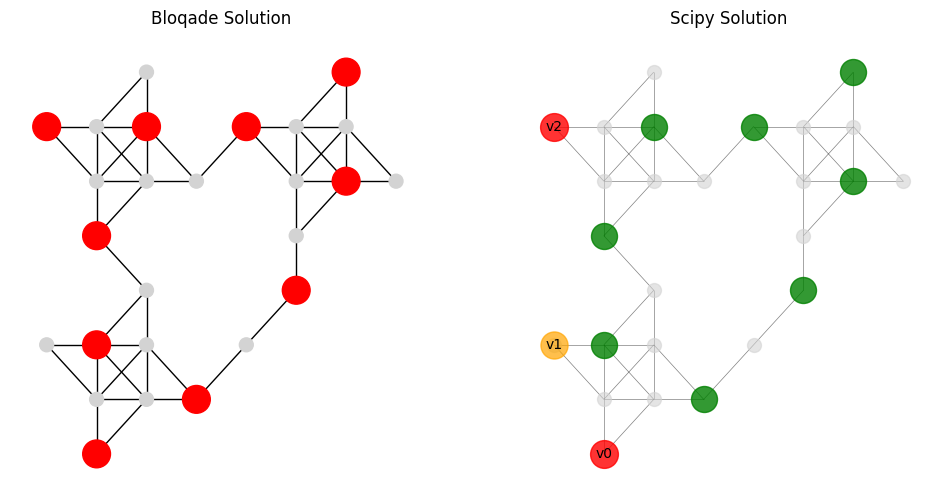

In [ ]:
visualize_bloqade_scipy_solution(locations, list(sorted_counts.items())[:2], udg.qubo_result, solution_vector)

### 3.4. Implementation with `pulser`

`pulser` is another Python library for programming and simulating neutral atom devices, focusing on pulse-level control. The `pulser_example.py` script demonstrates its usage.

**Steps:**

1.  **Prepare Inputs:** Similar to Bloqade, get scaled atom locations and normalized weights.

**Note!** we solve a smaller 2x2 Ising Problem, due to that the `Pulser` Emulator does not have a `subspace` method like `bloqade` does, therefore it has to simulate the whole system. A regular laptop can simulate ~ 15 nodes in 10 mins.

In [ ]:
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.channels.dmm import DMM
from pulser.devices import AnalogDevice, DigitalAnalogDevice
from pulser.register import Register
from pulser.sampler import sampler
from pulser.sequence import Sequence
from pulser.pulse import Pulse
from pulser.waveforms import ConstantWaveform, RampWaveform, CompositeWaveform, InterpolatedWaveform

from dataclasses import replace

In [ ]:
print("================================")
print("Demonstrating the mapping of an Ising model to a Unit Disk Graph")
print("and solving it with Pulser Emulator.")
# Create a simple Ising model
# Quadratic terms (J)
quad = {
    (0, 1): 1.0,   # Ferromagnetic coupling between qubits 0 and 1
}

# Linear terms (h)
linear = {
    0: 0.1,
    1: -0.2,
}

# Create the Ising model
ising_model = IsingModel(quad=quad, linear=linear, constant=0.0)

print("Created Ising model with:")
print(f"- {len(ising_model.quad)} quadratic terms")
print(f"- {len(ising_model.linear)} linear terms")
print(f"- {ising_model.num_bits()} qubits")

# Convert to a Unit Disk Graph
udg = Ising_UnitDiskGraph(ising_model)

print("\nConverted to Unit Disk Graph:")
print(f"- {len(udg.nodes)} nodes in the grid graph")
print(f"- {len(udg.pins)} pins corresponding to original variables")

# Step 1: Solve the QUBO problem
print("\nStep 1: Solve the QUBO problem with MWIS/scipy and brute force")
print("---------------------------")

# Solve the Ising model using the UDG representation
result = udg.solve(use_brute_force=True)  # For small problems, use brute force
solution_vector = result['solution_vector']

print(f"Solution found using {result['solution_method']} approach!")
print(f"Original configuration: {result['original_config']}")
print(f"Energy of the configuration: {result['energy']}")


# Step 2: Compare solution methods
print("\nStep 2: Compare solution methods")
print("-------------------------------")

if 'brute_force_result' in result and result['solution_method'] != "brute_force":
    bf_result = result['brute_force_result']
    print(f"Brute force minimum energy: {bf_result['min_energy']}")
    print(f"Brute force minimum configuration: {bf_result['best_config']}")
    print(f"MWIS solution energy: {result['energy']}")
    print(f"MWIS solution configuration: {result['original_config']}")

    # Show top 3 configurations from brute force
    print("\nTop configurations by energy:")
    for i, (config, energy) in enumerate(bf_result['all_configs'][:3]):
        print(f"{i+1}. Config {config}: Energy = {energy}")

    # Convert to string for comparison since float equality can be tricky
    if abs(bf_result['min_energy'] - result['energy']) < 1e-4 and str(bf_result['best_config']) == str(result['original_config']):
        print("\n✓ MWIS solution matches the brute force solution!")
    else:
        print("\n✗ MWIS solution differs from the brute force solution.")
        print("  Energy difference: ", abs(bf_result['min_energy'] - result['energy']))
elif result['solution_method'] == "brute_force":
    print("Using brute force solution directly (optimal solution guaranteed).")

    # Show top 3 configurations from brute force
    if 'brute_force_result' in result:
        print("\nTop configurations by energy:")
        for i, (config, energy) in enumerate(result['brute_force_result']['all_configs'][:3]):
            print(f"{i+1}. Config {config}: Energy = {energy}")
else:
    print("Brute force comparison not available for this problem size.")

Demonstrating the mapping of an Ising model to a Unit Disk Graph
and solving it with Pulser Emulator.
Created Ising model with:
- 1 quadratic terms
- 2 linear terms
- 2 qubits
Overwriting delta from 1.5 to 1.5

Converted to Unit Disk Graph:
- 8 nodes in the grid graph
- 2 pins corresponding to original variables

Step 1: Solve the QUBO problem with MWIS/scipy and brute force
---------------------------
Solution found using brute_force approach!
Original configuration: [-1, 1]
Energy of the configuration: -2.3000000000000003

Step 2: Compare solution methods
-------------------------------
Using brute force solution directly (optimal solution guaranteed).

Top configurations by energy:
1. Config [-1, 1]: Energy = -2.3000000000000003
2. Config [1, -1]: Energy = -1.7
3. Config [1, 1]: Energy = 1.9000000000000001


In [ ]:
qubo_result = udg.qubo_result
print(f"Mapping successful with {len(qubo_result.grid_graph.nodes)} nodes and {len(qubo_result.pins)} pins")

locations = qubo_grid_to_locations(qubo_result)
weights = qubo_result_to_weights(qubo_result)
print(f"Node weights: {weights}")
print(f"Node locations: {locations}")

Mapping successful with 8 nodes and 2 pins
Node weights: [1.3, 1.6, 5.0, 7.0, 7.0, 5.0, 1.4, 1.7]
Node locations: [(0.0, 10.0), (5.0, 0.0), (5.0, 5.0), (5.0, 10.0), (10.0, 5.0), (10.0, 10.0), (10.0, 15.0), (15.0, 5.0)]


2.  **Define Register and Device:** Create a `Register` with atom locations and choose a `Device` model (which defines constraints like blockade radius implicitly or explicitly).

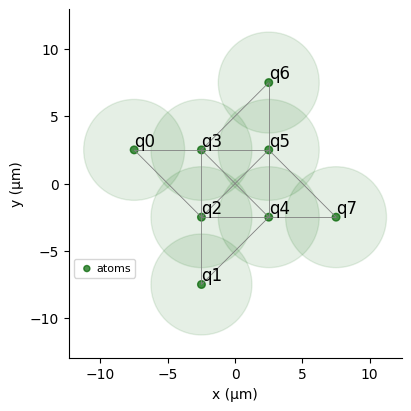

In [ ]:
# Create the register
qubits = {f"q{i}": coord for (i, coord) in enumerate(locations)}

register = Register.from_coordinates(
    locations, center=True, prefix="q"
)
register.draw(
    blockade_radius=7.5,
    draw_graph=True,
    draw_half_radius=True,
)

Next we need to define a local detuning map, such that $\Delta_i = w_i \times \Delta (t)$

*   **Important:** Implementing the *weighted* detuning $\delta_i(t) = w_i \times \delta_{global}(t)$ in Pulser typically requires more advanced features like local addressing channels or Digital Micromirror Devices (DMMs) if the target device supports them. The example above shows a simpler global pulse; consult Pulser documentation for implementing weighted detuning maps. The `pulser_example.py` uses DMMs, which is a more complex setup involving `DetuningMap`, `config_detuning_map`, and `add_dmm_detuning`.

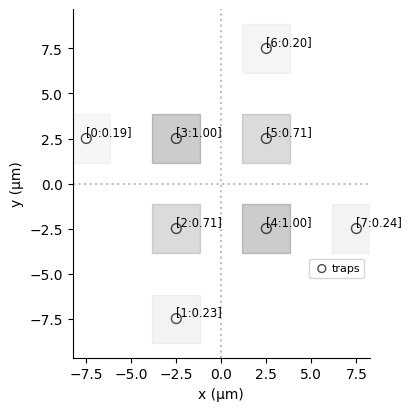

In [ ]:
# Normalize weights to be between 0 and 1 (required by Pulser)
lw = len(weights)
weights_norm =  [x/max(weights) for x in weights]
# inverse of the weights (later for creating the detuning map)
w_inv_norm = [1 - x for x in weights_norm]

dmap1 = register.define_detuning_map(
{ f"q{i}": weights_norm[i] for i in range(lw)}  # mapping between qubit ids and weights
)

dmap2 = register.define_detuning_map(
{ f"q{i}": w_inv_norm[i] for i in range(lw)}  # mapping between qubit ids and weights
)

dmap1.draw(labels=[i for i in range(lw)])

In [ ]:
# Configure DetuningMap
dmm = DMM(clock_period=4,
          min_duration=16,
          max_duration=2**26,
          mod_bandwidth=8,
          bottom_detuning=-2 * np.pi * 20,  # detuning between 0 and -20 MHz
          total_bottom_detuning=-2 * np.pi * 2000,  # total detuning
)

mock_device = replace(
    AnalogDevice.to_virtual(),
    dmm_objects=(dmm, DMM()),
    reusable_channels=True,
)
#print(mock_device.dmm_channels)

3.  **Define Pulses and Sequence:** Construct the pulse sequence using `pulser` objects. Implementing spatially varying detuning often requires `DetuningMap` and DMM channels if the device supports them, or applying pulses locally if using local addressing channels. For a simple adiabatic sweep similar to the Bloqade example using global pulses:

In [ ]:
seq = Sequence(register, mock_device)
seq.config_detuning_map(dmap1, "dmm_0")
seq.config_detuning_map(dmap2, "dmm_1")
#print(seq.declared_channels)

T = 5000 # ns
delta = 30.
Omega = 5
seq.add_dmm_detuning(RampWaveform(T, -delta, 0), "dmm_0", protocol="no-delay")
seq.add_dmm_detuning(ConstantWaveform(T, -delta/2), "dmm_1", protocol="no-delay")
seq.declare_channel("ryd_glob", "rydberg_global")

adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    ConstantWaveform(T, delta/2),
    0,
)
seq.add(adiabatic_pulse, "ryd_glob", protocol="no-delay")

Draw the system setting (Pulses) before simulation

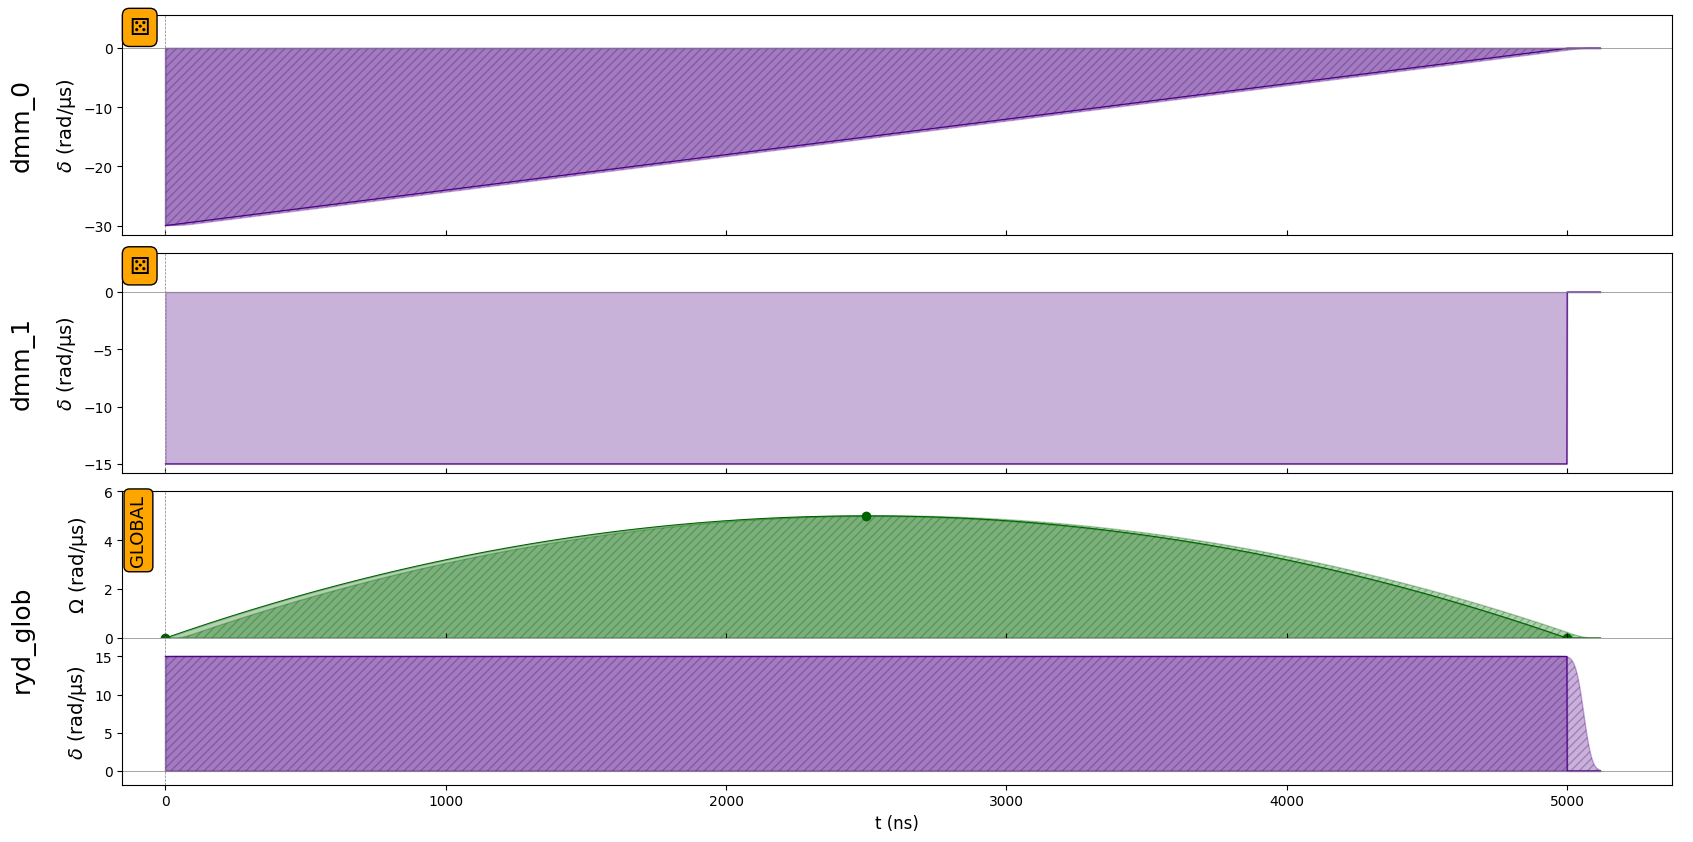

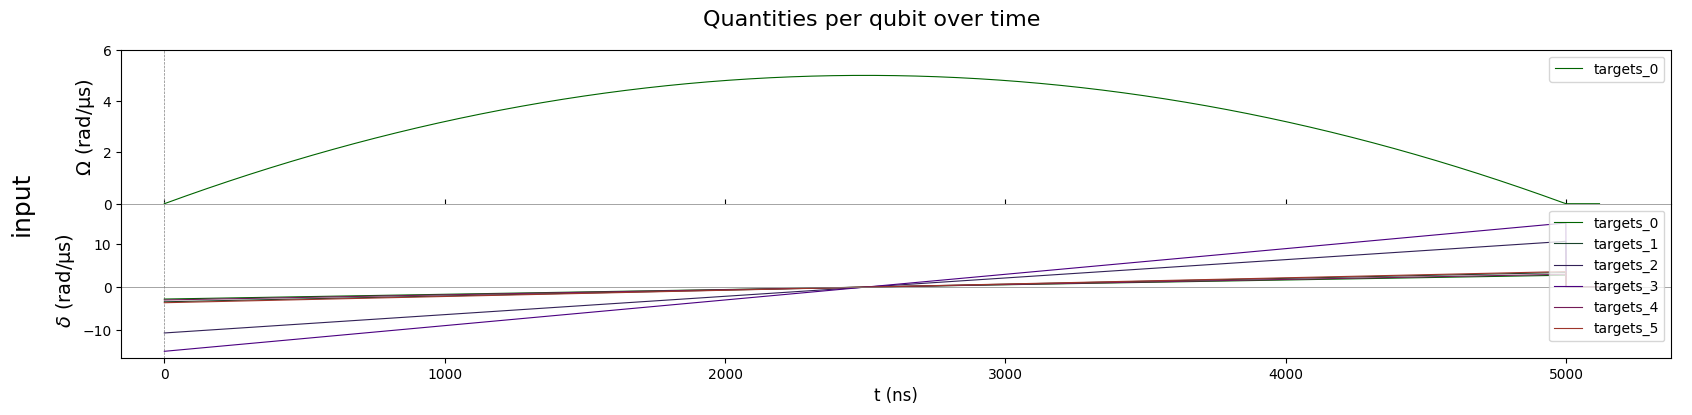

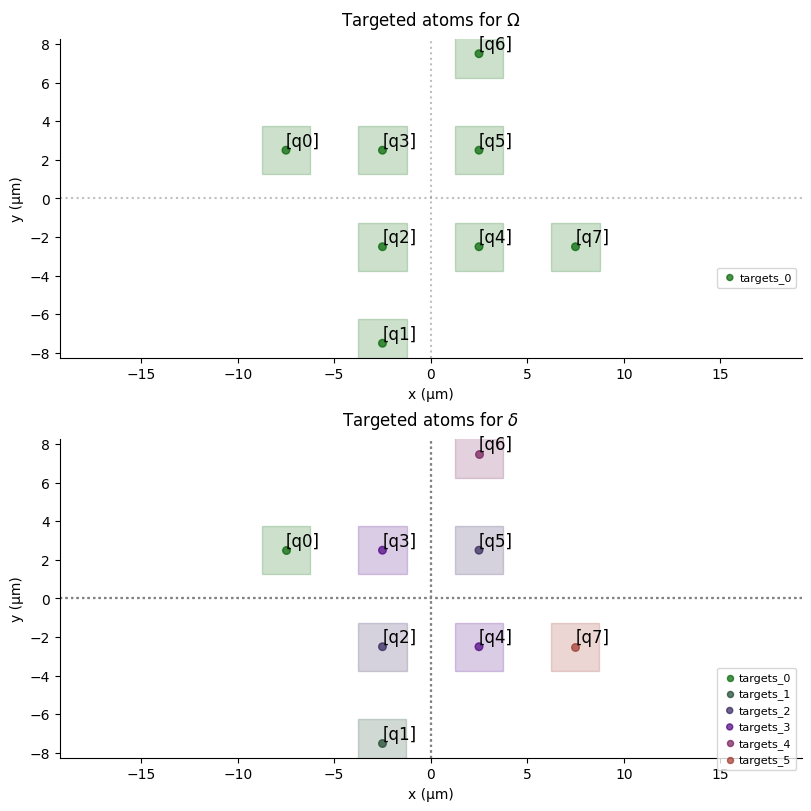

In [ ]:
seq.draw(
    mode="input+output",  # "input" only shows input signals, "input+output"
    draw_qubit_det=True,
    draw_qubit_amp=True,
)

4.  **Run the Simulation:** Use Pulser's emulator (`QutipEmulator`).

In [ ]:
from pulser_simulation import QutipEmulator

# Simulate the sequence
# Blockade is handled by the emulator based on C6 coeff and atom distances
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

# Sort by frequency
sorted_counts_pulser = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))

print("\nPulser Simulation Results (Top 5):")
for i, (bitstring, count) in enumerate(list(sorted_counts_pulser.items())[:5]):
    # Pulser bitstring '1' usually means Rydberg |r> (in IS), '0' means ground |g>
    print(f" {i+1}. Bitstring: {bitstring} (Count: {count})")

most_frequent_bs_pulser = list(sorted_counts_pulser.keys())[0] if sorted_counts_pulser else None


Pulser Simulation Results (Top 5):
 1. Bitstring: 01010001 (Count: 344)
 2. Bitstring: 10001010 (Count: 132)
 3. Bitstring: 00011000 (Count: 91)
 4. Bitstring: 00001010 (Count: 74)
 5. Bitstring: 01010000 (Count: 74)


In [ ]:
# Below combines all the steps together, while setting the experiment parameters as function arguments.

"""
def solve_ising_pulser(locations, weights, delta_max=30, Omega_max=5, t_max=5000):
    # Create a register with the given locations
    register = Register.from_coordinates(locations, center=True, prefix="q")
    # register.draw(blockade_radius=7.5, draw_graph=True, draw_half_radius=True) # Uncomment if want to visualize the register
    lw = len(weights)
    # Normalize weights to be between 0 and 1 (required by Pulser)
    weights_norm =  [x/max(weights) for x in weights]
    # inverse of the weights (later for creating the detuning map)
    w_inv_norm = [1 - x for x in weights_norm]

    dmap1 = register.define_detuning_map(
    { f"q{i}": weights_norm[i] for i in range(lw)}  # mapping between qubit ids and weights
    )
    # dmap1.draw(labels=[i for i in range(lw)]) # Uncomment if want to visualize the detuning map
    dmap2 = register.define_detuning_map(
    { f"q{i}": w_inv_norm[i] for i in range(lw)}  # mapping between qubit ids and weights
    )

    # Configure DetuningMap
    dmm = DMM(clock_period=4,
              min_duration=16,
              max_duration=2**26,
              mod_bandwidth=8,
              bottom_detuning=-2 * np.pi * 20,  # detuning between 0 and -20 MHz
              total_bottom_detuning=-2 * np.pi * 2000,  # total detuning
    )

    mock_device = replace(
        AnalogDevice.to_virtual(),
        dmm_objects=(dmm, DMM()),
        reusable_channels=True,
    )
    #print(mock_device.dmm_channels)

    seq = Sequence(register, mock_device)
    seq.config_detuning_map(dmap1, "dmm_0")
    seq.config_detuning_map(dmap2, "dmm_1")
    #print(seq.declared_channels)

    T = t_max
    delta = delta_max
    Omega = Omega_max
    seq.add_dmm_detuning(RampWaveform(T, -delta, 0), "dmm_0", protocol="no-delay")
    seq.add_dmm_detuning(ConstantWaveform(T, -delta/2), "dmm_1", protocol="no-delay")
    seq.declare_channel("ryd_glob", "rydberg_global")

    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        ConstantWaveform(T, delta/2),
        0,
    )
    seq.add(adiabatic_pulse, "ryd_glob", protocol="no-delay")

    return seq
"""

*   The emulator calculates the interactions based on the register geometry and the device's $C_6$ coefficient, implicitly handling the blockade.
    *   `sample_final_state` provides the counts for different output bitstrings. Again, check the convention ('0'/'1' vs $|g\rangle$/$|r\rangle$). Pulser often uses '1' for the Rydberg state $|r\rangle$.

### 3.5. Comparison and Visualization

After obtaining results from both the classical MILP solver and the quantum simulators (Bloqade/Pulser), it's essential to compare them.

*   **Map Back:** Ensure all results are mapped back to the original Ising spin configuration ($z_i \in \{-1, +1\}$) for a fair comparison. Remember the different bitstring conventions.
*   **Energy Calculation:** Calculate the energy of the configurations found by each method using the original Ising Hamiltonian (`ising_model.calc_energy(config)`).
*   **Visualization:** Create plots comparing the solutions, similar to `visualize_bloqade_scipy_solution` in the example scripts. This involves plotting the UDG graph and coloring the nodes based on whether they were selected in the MWIS found by the classical solver versus the most probable state(s) from the quantum simulation.

In [ ]:
def visualize_pulser_scipy_solution(locations, top2, qubo_result, solution_vector, output_file="img/compare_solution.png"):
    """
    Visualize the Bloqade solution and scipy solution side by side.

    Args:
        locations: List of (x, y) tuples for node locations
        top2: Top 2 solutions from Bloqade
        qubo_result: QUBOResult from map_qubo
        solution_vector: Binary solution vector from MWIS solver
        output_file: Path to save the visualization
    """
    # Function to create a graph with nodes at fixed locations.
    def create_graph(locs, threshold):
        G = nx.Graph()
        for idx, pos in enumerate(locs):
            G.add_node(idx, pos=pos)

        # Add edges based on distance threshold
        for i in range(len(locs)):
            for j in range(i + 1, len(locs)):
                dist = np.linalg.norm(np.array(locs[i]) - np.array(locs[j]))
                if dist < threshold:
                    G.add_edge(i, j)

        return G

    # Create two graphs (they share the same node positions)
    G1 = create_graph(locations, 7.5)
    G2 = nx.Graph()

    # Retrieve node positions from one of the graphs.
    pos = nx.get_node_attributes(G1, 'pos')

    # Determine node colors for each graph based on the corresponding bitstring.
    bitstr1 = top2[0][0]

    node_colors1 = ['red' if bit == '1' else 'lightgray' for bit in bitstr1]
    node_size1 = [400 if bit == '1' else 100 for bit in bitstr1]

    # Create subplots with two axes (side by side)
    fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

    # Draw the first graph.
    nx.draw(G1, pos, ax=axes[0], with_labels=False, node_color=node_colors1, node_size=node_size1)
    axes[0].set_title(f"Pulser Solution")

    # Add nodes with positions from the grid graph
    for i, node in enumerate(qubo_result.grid_graph.nodes):
        G2.add_node(i, pos=node.loc, weight=node.weight)

    # Add edges based on unit disk constraint
    radius = qubo_result.grid_graph.radius
    for i in range(len(qubo_result.grid_graph.nodes)):
        for j in range(i+1, len(qubo_result.grid_graph.nodes)):
            node1 = qubo_result.grid_graph.nodes[i]
            node2 = qubo_result.grid_graph.nodes[j]
            dist = np.sqrt(sum((np.array(node1.loc) - np.array(node2.loc))**2))
            if dist <= radius:
                G2.add_edge(i, j)

    # Get positions
    pos = nx.get_node_attributes(G2, 'pos')

    # Selected nodes (part of the solution)
    selected_nodes = [i for i in range(len(qubo_result.grid_graph.nodes))
                      if round(solution_vector[i]) == 1]

    # Non-selected nodes
    non_selected = [i for i in range(len(qubo_result.grid_graph.nodes))
                    if i not in selected_nodes]

    # Pin nodes
    pin_nodes = qubo_result.pins

    # Draw edges
    nx.draw_networkx_edges(G2, pos, ax=axes[1], width=0.5, alpha=0.5)

    # Draw non-selected nodes
    if non_selected:
        nx.draw_networkx_nodes(G2, pos, ax=axes[1],nodelist=non_selected,
                             node_color='lightgray', node_size=100, alpha=0.6)

    # Draw selected nodes
    if selected_nodes:
        # Color selected nodes that are also pins
        selected_pins = [n for n in selected_nodes if n in pin_nodes]
        selected_regular = [n for n in selected_nodes if n not in pin_nodes]

        # Draw selected regular nodes
        if selected_regular:
            nx.draw_networkx_nodes(G2, pos, ax=axes[1], nodelist=selected_regular,
                                 node_color='green', node_size=350, alpha=0.8)

        # Draw selected pin nodes
        if selected_pins:
            nx.draw_networkx_nodes(G2, pos, ax=axes[1], nodelist=selected_pins,
                                 node_color='red', node_size=400, alpha=0.8)

    # Draw non-selected pin nodes
    non_selected_pins = [n for n in pin_nodes if n not in selected_nodes]
    if non_selected_pins:
        nx.draw_networkx_nodes(G2, pos, ax=axes[1], nodelist=non_selected_pins,
                             node_color='orange', node_size=380, alpha=0.7)

    # Add pin labels
    pin_labels = {pin: f"v{i}" for i, pin in enumerate(pin_nodes)}
    nx.draw_networkx_labels(G2, pos, ax=axes[1], labels=pin_labels, font_size=10)

    # Draw the second graph.
    #nx.draw(G2, pos, ax=axes[1], with_labels=True, node_color=node_colors2, node_size=500)
    axes[1].set_axis_off()
    axes[1].set_title(f"Scipy Solution")

    #plt.title("MWIS Solution on Unit Disk Graph")
    #plt.axis('equal')

    #plt.savefig(output_file)
    #plt.close()
    plt.show()

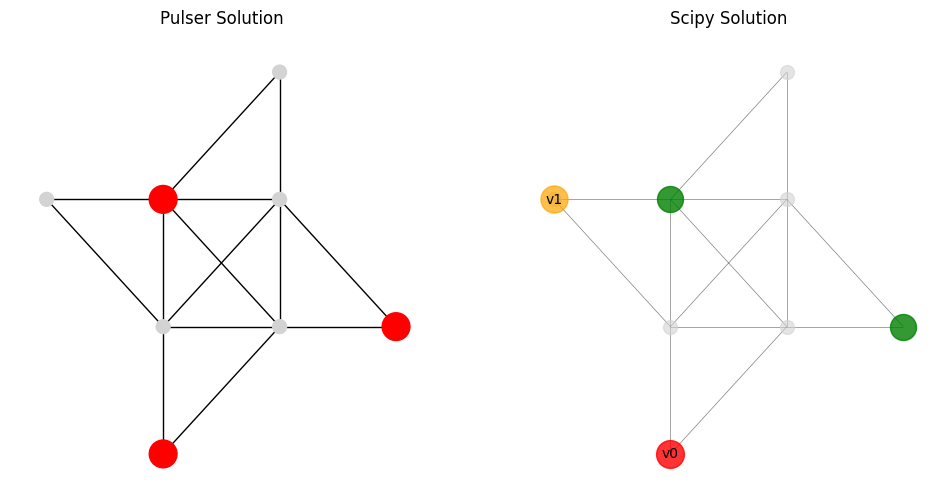

In [ ]:
visualize_pulser_scipy_solution(locations, list(sorted_counts_pulser.items())[:2], qubo_result, solution_vector)

Discrepancies between the classical and quantum simulation results can arise from non-adiabatic evolution (simulation time `t_max` too short), decoherence effects (not modeled here), or differences in how weights/pulses are implemented in each framework.

This section outlined the physics behind solving MWIS on neutral atom arrays and demonstrated how to simulate this process using `bloqade-analog` and `pulser`, starting from the UDG generated by `qamomile`.

## 4. Summary and Conclusion

Neutral atom quantum computers offer a powerful platform for tackling complex optimization problems. However, their native interactions, governed by the Rydberg blockade effect, naturally lend themselves to problems defined on Unit-Disk Graphs (UDGs), where connectivity is limited by distance. Many important problems, such as general QUBO or Ising models, feature arbitrary connectivity, posing a challenge for direct implementation.

This tutorial explored the **Unit-Disk Mapping (UDM)** technique, specifically its formulation via the Maximum Weight Independent Set (MWIS) problem, as a method to bridge this gap. We demonstrated how:
1.  Arbitrarily connected QUBO/Ising problems can be systematically mapped onto an MWIS problem on a specially constructed UDG using geometric gadgets.
2.  The `qamomile` library facilitates this mapping process, converting an `IsingModel` definition into a `UnitDiskGraph` representation suitable for simulation or hardware execution.
3.  The resulting MWIS-UDG problem can be solved classically using standard methods like Mixed-Integer Linear Programming (MILP), as implemented via `scipy.optimize.milp`.
4.  Alternatively, the MWIS-UDG problem can be solved using adiabatic evolution protocols on neutral atom platforms, leveraging the Rydberg blockade to enforce the independent set constraint. We showed how to simulate this process using the `bloqade-analog` and `pulser` frameworks.

The UDM technique, combined with the programmability of neutral atom arrays, opens up avenues for applying these quantum devices to a broader class of optimization problems beyond those with native geometric constraints. While the mapping introduces an overhead in the number of required qubits (nodes in the UDG), ongoing research explores optimization techniques to minimize this overhead for specific problem structures. As neutral atom hardware continues to scale and improve, techniques like UDM will be crucial for unlocking their potential for practical combinatorial optimization.

## 5. References

*   **Unit-Disk Mapping Paper:**
    Nguyen, M. T., Das, S., Weidinger, L., Staudacher, S., Katz, O., Häner, T., ... & Cong, I. (2023). Quantum Optimization with Arbitrary Connectivity Using Rydberg Atom Arrays. *PRX Quantum*, *4*(1), 010316. [DOI: 10.1103/PRXQuantum.4.010316](https://doi.org/10.1103/PRXQuantum.4.010316)

*   **Bloqade-analog:**
    [https://queracomputing.github.io/bloqade-analog/latest/](https://queracomputing.github.io/bloqade-analog/)

*   **Pulser:**
    [https://github.com/pasqal-io/Pulser](https://github.com/pasqal-io/Pulser)
    Silver, L. S., Henry, L. P., Le Régent, A., Valentin, C., & Henriet, L. (2022). Pulser: An open-source package for the design of pulse sequences in neutral-atom quantum devices. *Quantum*, *6*, 629. [DOI: 10.22331/q-2022-01-24-629](https://doi.org/10.22331/q-2022-01-24-629)
